In [3]:
import torch
import torch.distributed as dist
import torch.nn as nn
import torch.optim as optim
import yaml
from torch.nn.parallel import DistributedDataParallel as DDP
import sys, os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributed as dist
import torch.multiprocessing as mp
import torchvision
import torchvision.transforms as transforms
from torch.nn.parallel import DistributedDataParallel
from torch.utils.data import Dataset
import torch.optim as optim
# root_dir = '/mnt/home/spandey/ceph/CHARM/'
# os.chdir(root_dir)
import pickle as pk
# sys.path.append(root_dir)
# sys.path.append(root_dir)
import pathlib
curr_path = pathlib.Path().absolute()
src_path = os.path.abspath(curr_path / "../src/") 
sys.path.append(src_path)
from combined_models import *
from all_models import *
from utils_data_prep_cosmo_vel import *
from colossus.cosmology import cosmology
params = {'flat': True, 'H0': 67.11, 'Om0': 0.3175, 'Ob0': 0.049, 'sigma8': 0.834, 'ns': 0.9624}
cosmo = cosmology.setCosmology('myCosmo', **params)
from colossus.lss import mass_function
from tqdm import tqdm
import sparse
import numpy as np
import h5py as h5
import torch
from torch.nn import functional as F
from dataclasses import dataclass
from contextlib import nullcontext
from dataclasses import dataclass
from torch.nn.parallel import DistributedDataParallel as DDP
import matplotlib.pyplot as pl

import os
%load_ext autoreload
%autoreload 2
%matplotlib inline


def setup(rank, world_size):
    # initialize the process group
    dist.init_process_group("nccl", rank=rank, world_size=world_size)

def cleanup():
    dist.destroy_process_group()


def get_data_split(dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed, delta_box_all_squeezed, n1_fac=0.8, n2_fac=1.0):
    n1 = int(n1_fac*len(dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed))
    n2 = int(n2_fac*len(dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed))
    train_data_halos = dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed[:n1]
    val_data_halos = dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed[n1:n2]

    train_data_dm = delta_box_all_squeezed[:n1]
    val_data_dm = delta_box_all_squeezed[n1:n2]

    x = torch.tensor(train_data_halos[:, :-1])
    y = torch.tensor(train_data_halos[:, 1:])
    dm = torch.tensor(train_data_dm)
    mask_train_orig = x != 1
    mask_train = torch.logical_not(mask_train_orig)
    masked_logits = torch.zeros(mask_train.shape)
    mask_train_final = masked_logits.masked_fill(mask_train, float('-inf'))
    mask_train = mask_train_final[:,None,:]
    x, y = torch.tensor(x), torch.tensor(y)
    x_train = x.long()
    y_train = y.long()
    dm_train = dm.bfloat16()
    mask_train = torch.tensor(mask_train).bfloat16()

    x = torch.tensor(val_data_halos[:, :-1])
    y = torch.tensor(val_data_halos[:, 1:])
    dm = torch.tensor(val_data_dm)
    mask_val_orig = x != 1
    mask_val = torch.logical_not(mask_val_orig)
    masked_logits = torch.zeros(mask_val.shape)
    mask_val_final = masked_logits.masked_fill(mask_val, float('-inf'))
    mask_val = mask_val_final[:,None,:]
    x, y = torch.tensor(x), torch.tensor(y)
    x_val = x.long()
    y_val = y.long()
    dm_val = dm.bfloat16()
    mask_val = torch.tensor(mask_val).bfloat16()

    return x_train, y_train, dm_train, mask_train, x_val, y_val, dm_val, mask_val

run_config_name = 'TRAIN_VEL_FREECOSMO_cond_fastpm_ns128.yaml'
with open("/mnt/home/spandey/ceph/CHARM/run_configs/" + run_config_name,"r") as file_object:
    config=yaml.load(file_object,Loader=yaml.SafeLoader)


config_sims = config['sim_settings']
ji_array = np.arange(int(config_sims['nsims']))
nsubvol_per_ji = int(config_sims['nsubvol_per_ji'])
nsubvol_fid = int(config_sims['nsubvol_fid'])
subsel_criteria = config_sims['subsel_criteria']
num_cosmo_params = int(config_sims['num_cosmo_params'])
ns_d = config_sims['ns_d']
nb = config_sims['nb']
nax_d =  ns_d // nb
nf = config_sims['nf']
layers_types = config_sims['layers_types']
z_inference = config_sims['z_inference']
nc = 0
for jl in range(len(layers_types)):
    if layers_types[jl] == 'cnn':
        nc += 1
    elif layers_types[jl] == 'res':
        nc += 2
    else:
        raise ValueError("layer type not supported")

z_all = config_sims['z_all']
z_all_FP = config_sims['z_all_FP']
# z_all_FP = z_all_FP[:-1]
z_all_FP = z_all_FP
ns_h = config_sims['ns_h']
nax_h = ns_h // nb
cond_sim = config_sims['cond_sim']

nsims_per_batch = config_sims['nsims_per_batch']
nbatches_train = config_sims['nbatches_train']

mass_type = config_sims['mass_type']
lgMmin = config_sims['lgMmin']
lgMmax = config_sims['lgMmax']
stype = config_sims['stype']
rescale_sub = config_sims['rescale_sub']
lgMmincutstr = config_sims['lgMmincutstr']
# subsel_highM1 = config_sims['subsel_highM1']
# nsubsel = config_sims['nsubsel']
is_HR = config_sims['is_HR']

try:
    Nmax = config_sims['Nmax']
except:
    Nmax = 4

config_net = config['network_settings']
hidden_dim_MAF = config_net['hidden_dim_MAF']
learning_rate = config_net['learning_rate']
# K_M1 = config_net['K_M1']
# B_M1 = config_net['B_M1']
# nflows_M1_NSF = config_net['nflows_M1_NSF']

K_vel = config_net['K_vel']
B_vel = config_net['B_vel']
nflows_vel_NSF = config_net['nflows_vel_NSF']

# base_dist_Ntot = config_net['base_dist_Ntot']
# if base_dist_Ntot == 'None':
#     base_dist_Ntot = None
# base_dist_M1 = config_net['base_dist_M1']
base_dist_vel = config_net['base_dist_vel']
# ngauss_M1 = config_net['ngauss_M1']
cond_Mass_for_vel = config_net['cond_Mass_for_vel']

changelr = config_net['changelr']
ksize = nf
nfeature_cnn = config_net['nfeature_cnn']
nout_cnn = 4 * nfeature_cnn
if cond_sim == 'fastpm':
    if any('v' in str(string) for string in z_all_FP):
        ninp = len(z_all_FP) + 2
    else:
        ninp = len(z_all_FP)

elif cond_sim == 'quijote':
    ninp = len(z_all)
else:
    raise ValueError("cond_sim not supported")

num_cond = nout_cnn + ninp + num_cosmo_params




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import pickle as pk
# df = pk.load(open('/mnt/home/spandey/ceph/CHARM/data/HALO_MASS_VEL_varycosmo_subsel_random_nsims1800_nspji16_nfid512_train_data_QUIJOTE.pk', 'rb'))
df = pk.load(open('/mnt/home/spandey/ceph/CHARM/data/HALO_MASS_test1000_QUIJOTE_test.pk', 'rb'))

df_d_all_train = df['df_d_all_train']
df_d_all_nsh_train = df['df_d_all_nsh_train']
df_Mh_all_train = df['df_Mh_all_train'].todense()
df_Nh_train = df['df_Nh_train'].todense()
df_vh_train = df['df_vh_train'].todense()
ind_subsel_all_train = df['ind_subsel_all_train']
ind_subsel_fid_train = df['ind_subsel_fid_train']
cosmo_val_all_train = df['cosmo_val_all_train']

import pickle as pk
# df = pk.load(open('/mnt/home/spandey/ceph/CHARM/data/DENSITY_varycosmo_subsel_random_nsims1800_nspji16_nfid512_train_data_FASTPM.pk', 'rb'))
df = pk.load(open('/mnt/home/spandey/ceph/CHARM/data/DENSITY_test1000_FASTPM_test.pk', 'rb'))
df_d_all_train_FP = df['df_d_all_train']
df_d_all_nsh_train_FP = df['df_d_all_nsh_train']
df_Mh_all_train_FP = df['df_Mh_all_train']
df_Nh_train_FP = df['df_Nh_train']
df_vh_train_FP = None
ind_subsel_all_train_FP = df['ind_subsel_all_train']
ind_subsel_fid_train_FP = df['ind_subsel_fid_train']
cosmo_val_all_train_FP = df['cosmo_val_all_train']




In [5]:
# indall = np.arange(len(df_Mh_all_train))
# np.random.shuffle(indall)
# Nindsel = len(indall)//4
# indsel = indall[:Nindsel]
# df_Mh_all_train = sparse.COO(df_Mh_all_train[indsel,...])
# df_Nh_train = sparse.COO(df_Nh_train[indsel,...])
# df_vh_train = sparse.COO(df_vh_train[indsel,...])
# saved = {'df_d_all_train': df_d_all_train, 'df_d_all_nsh_train': df_d_all_nsh_train, 'df_Mh_all_train': df_Mh_all_train, 'df_Nh_train': df_Nh_train, 'df_vh_train':df_vh_train, 'ind_subsel_all_train': ind_subsel_all_train, 'ind_subsel_fid_train': ind_subsel_fid_train, 'cosmo_val_all_train': cosmo_val_all_train}
# pk.dump(saved, open(f'/mnt/home/spandey/ceph/CHARM/data/HALO_MASS_test{Nindsel}_QUIJOTE_test.pk', 'wb'))


# df_d_all_train_FP = df_d_all_train_FP[indsel,...]
# df_d_all_nsh_train_FP = df_d_all_nsh_train_FP[indsel,...]
# cosmo_val_all_train_FP = cosmo_val_all_train_FP[indsel,...]
# saved = {'df_d_all_train': df_d_all_train_FP, 'df_d_all_nsh_train': df_d_all_nsh_train_FP, 'cosmo_val_all_train': cosmo_val_all_train_FP, 'df_Mh_all_train':df_Mh_all_train_FP, 'df_Nh_train':df_Nh_train_FP, 'df_vh_train':df_vh_train, 'ind_subsel_all_train': ind_subsel_all_train_FP, 'ind_subsel_fid_train': ind_subsel_fid_train_FP}
# pk.dump(saved, open(f'/mnt/home/spandey/ceph/CHARM/data/DENSITY_test{Nindsel}_FASTPM_test.pk', 'wb'))




In [4]:
# # Prepare the density and halo data
nsims_per_batch = 1000
nbatches_train = 1
return_dict_train = prep_density_halo_cats_batched(
    df_d_all_train, df_d_all_nsh_train, df_Mh_all_train, df_Nh_train,cosmo_val_all_train, df_v_inp=df_vh_train, nsims=nsims_per_batch,
    nbatches = nbatches_train, Mmin=lgMmin, Mmax=lgMmax, rescaleM_sub=rescale_sub, Nmax=Nmax, get_density=False, get_halos=True
    )


# # Prepare the density and halo data
return_dict_train_FP = prep_density_halo_cats_batched(
    df_d_all_train_FP, df_d_all_nsh_train_FP, df_Mh_all_train_FP, df_Nh_train_FP, cosmo_val_all_train_FP, df_v_inp=df_vh_train_FP, nsims=nsims_per_batch,
    nbatches = nbatches_train, Mmin=lgMmin, Mmax=lgMmax, rescaleM_sub=rescale_sub, get_density=True, get_halos=False
    )

if return_dict_train_FP is not None:
    cond_tensor = torch.Tensor(np.array(return_dict_train_FP['df_d_all']))
    cond_nsh = np.moveaxis(np.array(return_dict_train_FP['df_d_all_nsh']), 2, 5)
    cond_tensor_nsh = torch.Tensor((cond_nsh)).reshape(-1, nsims_per_batch * (nax_h ** 3), ninp)
    
    cond_cosmo = torch.Tensor(np.array(return_dict_train_FP['cosmo_val_all']))
    cond_cosmo = cond_cosmo.reshape(-1, nsims_per_batch * (nax_h**3), cond_cosmo.shape[-1])
else:
    cond_tensor = torch.Tensor(np.array(return_dict_train['df_d_all']))
    cond_nsh = np.moveaxis(np.array(return_dict_train['df_d_all_nsh']), 2, 5)
    cond_tensor_nsh = torch.Tensor((cond_nsh)).reshape(-1, nsims_per_batch * (nax_h ** 3), ninp)

    cond_cosmo = torch.Tensor(np.array(return_dict_train['cosmo_val_all']))
    cond_cosmo = cond_cosmo.reshape(-1, nsims_per_batch * (nax_h**3), cond_cosmo.shape[-1])


ndim_mass = Nmax
ndim_vel = 3*Nmax

v_halos_all = return_dict_train['v_halos_all_sort_norm'].reshape(*return_dict_train['v_halos_all_sort_norm'].shape[:-2],-1)
M_halos_all = return_dict_train['M_halos_all_sort_norm'].reshape(*return_dict_train['M_halos_all_sort_norm'].shape[:-2],-1)

mask_vel = return_dict_train['mask_vel']
mask_vel_repeat = np.repeat(mask_vel[..., None], 3, axis=-1)
mask_vel_repeat = mask_vel_repeat.reshape(*mask_vel_repeat.shape[:-2],-1)
mask_tensor_vel_train = torch.Tensor((mask_vel_repeat)).reshape(-1, nsims_per_batch * (nax_h**3), ndim_vel)


X_vel = torch.Tensor(np.array(v_halos_all)).reshape(-1, nsims_per_batch * (nax_h**3),ndim_vel)
Nhalos_truth_tensor = torch.Tensor(((np.array(return_dict_train['N_halos_all'])))).reshape(-1, nsims_per_batch * (nax_h**3), 1)
Mhalos_truth_tensor = torch.Tensor(((np.array(M_halos_all)))).reshape(-1, nsims_per_batch * (nax_h**3), ndim_mass)


lgM_array = np.linspace(lgMmin, lgMmax, 1000)
M_array = 10**lgM_array
if '200c' in mass_type:
    hmf = mass_function.massFunction(M_array, float(z_inference), mdef = '200c', model = 'tinker08', q_out = 'dndlnM')
if 'vir' in mass_type:
    hmf = mass_function.massFunction(M_array, float(z_inference), mdef = 'vir', model = 'tinker08', q_out = 'dndlnM')    
if 'fof' in mass_type:
    hmf = mass_function.massFunction(M_array, float(z_inference), mdef = 'fof', model = 'bhattacharya11', q_out = 'dndlnM')
lgM_rescaled = rescale_sub + (lgM_array - lgMmin)/(lgMmax-lgMmin)

int_val = sp.integrate.simps(hmf, lgM_rescaled)
hmf_pdf = hmf/int_val
# define the cdf of the halo mass function
hmf_cdf = np.zeros_like(hmf_pdf)
for i in range(len(hmf_cdf)):
    hmf_cdf[i] = sp.integrate.simps(hmf_pdf[:i+1], lgM_rescaled[:i+1])

with open("/mnt/home/spandey/ceph/CHARM/run_configs/" + run_config_name,"r") as file_object:
    config=yaml.load(file_object,Loader=yaml.SafeLoader)

config_train = config['train_settings']
batch_size = config_train['batch_size_DL']
all_gpu = config_train['all_gpu']

try:
    L2norm_Ntothist = config_train['L2norm_Ntothist']
except:
    L2norm_Ntothist = False

try:
    L2norm_M1hist = config_train['L2norm_M1hist']
except:
    L2norm_M1hist = False

nflows_train = config_train['nflows_train']

# save_bestfit_model_dir = '/mnt/home/spandey/ceph/AR_NPE/' + 'TRAIN_ROCKSTAR_FOF/CLIPPED_FINALTEST_SUBSEL_Ntot_M1_Mdiff_plexp_ns_' + str(len(ji_array)) + \
#                             '_cond_sim_' + cond_sim  \
#                             + '_nc' + str(nc) + '_mass_' + mass_type + \
#                             '_KM1_' + str(K_M1) + \
#                             '_stype_' + stype + \
#                             '_L2normNtothist_' + str(L2norm_Ntothist) + '_L2normM1hist_' + str(L2norm_M1hist) + '_TRY2'

save_string = config_train['save_string']

# sdir_model_checkpoint = '/mnt/home/spandey/ceph/CHARM/model_checkpoints' + \
#                         '/MULT_GPU_ONLY_VELOCITY_nsims_' + \
#                             str(len(ji_array)) + \
#                             '_mass_' + mass_type + \
#                              '_Nmax' + str(Nmax) + save_string


# # print(save_bestfit_model_dir, os.path.exists(save_bestfit_model_dir))
# # make directory if it doesn't exist
# import os
# if not os.path.exists(save_bestfit_model_dir):
#     os.makedirs(save_bestfit_model_dir)


nepochs_Ntot_only = config_train['nepochs_Ntot_only']
nepochs_Ntot_M1_only = config_train['nepochs_Ntot_M1_only']
nepochs_all = config_train['nepochs_all']


from dataclasses import dataclass
# if __name__ == '__main__':
    # hyperparameters
    # batch_size = 16 # how many independent sequences will we process in parallel?
    # block_size = 32 # what is the maximum context length for predictions?
max_iters = 8000
eval_interval = 10
learning_rate = 2e-3
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 96
n_head = 4
n_layer = 4
dropout = 0.2
# ------------
# vocab_size = 131
# block_size = 161


batch_size = 2048




/tmp/ipykernel_931757/588732002.py:59: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  int_val = sp.integrate.simps(hmf, lgM_rescaled)
/tmp/ipykernel_931757/588732002.py:64: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  hmf_cdf[i] = sp.integrate.simps(hmf_pdf[:i+1], lgM_rescaled[:i+1])


In [12]:
# len_batches
cond_tensor.shape, cond_tensor_nsh.shape


(torch.Size([1, 1000, 4, 24, 24, 24]), torch.Size([1, 4096000, 4]))

In [13]:

# def run_func():

device = 'cuda'
compile = True # use PyTorch 2.0 to compile the model to be faster
torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn
device_type = 'cuda'
dtype = 'bfloat16'
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = torch.amp.autocast(device_type=device_type, dtype=ptdtype)

# dist.init_process_group("nccl")
# rank = dist.get_rank()
# print(f"Start running basic DDP example on rank {rank}.")

# create model and move it to GPU with id rank
# device_id = rank % torch.cuda.device_count()
device_id = 0

dtype = 'bfloat16'
# if rank == 0: print(f"Loading data", flush=True)    
# f = h5.File('/mnt/home/spandey/ceph/CHARFORMER/data/df_halo_part_ngp_xyzM_tokenized_density3Dgrid_32_isim_012_snap_3.h5', 'r')
# if rank == 0: print(f"Loaded data", flush=True)        

# x_train, y_train, dm_train, mask_train, x_val, y_val, dm_val, mask_val = get_data_split(dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed_all, delta_box_all_squeezed_all, 0.8, 1.0)
# if rank == 0: print(f"Got split with sizes {x_train.shape} and {x_val.shape}", flush=True)        

# labels = torch.randn(20, 5).to(device_id)
# if rank == 0: print(f"Transferred labels to GPU", flush=True)      
len_batches = cond_tensor.shape[0]
start = 0
# end = start + (len_batches // 16)
end = start + 1
# x_train_gpu = (x_train[start:end,...]).to(device_id, non_blocking=True)
# dm_train_gpu = (dm_train[start:end,...]).to(device_id, non_blocking=True)
# mask_train_gpu = (mask_train[start:end,...]).to(device_id, non_blocking=True)
# y_train_gpu = (y_train[start:end,...]).to(device_id, non_blocking=True)

cond_tensor_jb = cond_tensor[start:end,...].to(device_id, non_blocking=True)
cond_tensor_nsh_jb = cond_tensor_nsh[start:end,...].to(device_id, non_blocking=True)
cond_cosmo_jb = cond_cosmo[start:end,...].to(device_id, non_blocking=True)
Nhalos_truth_tensor_jb = Nhalos_truth_tensor[start:end,...].to(device_id, non_blocking=True)
if cond_Mass_for_vel:
    Mhalos_truth_tensor_jb = Mhalos_truth_tensor[start:end,...].to(device_id, non_blocking=True)
else:
    Mhalos_truth_tensor_jb = None
mask_tensor_vel_train_jb = mask_tensor_vel_train[start:end,...].to(device_id, non_blocking=True)

X_vel_jb = X_vel[start:end,...].to(device_id, non_blocking=True)

# print(f"I am rank {rank} and will process train data from {start} to {end}.")
# if rank == 0: print(f"Transferred train data to GPU", flush=True)        
    
num_cond_Ntot = num_cond

if cond_Mass_for_vel:
    num_cond_vel = num_cond + ndim_mass
else:
    num_cond_vel = num_cond

model_vel = NSF_Autoreg_CNNcond(
    dim=ndim_vel,
    K=K_vel,
    B=B_vel,
    hidden_dim=hidden_dim_MAF,
    num_cond=num_cond_vel,
    nflows=nflows_vel_NSF,
    base_dist=base_dist_vel,
    mu_pos=False
    )


# ndim = ndim_diff + 1
model = COMBINED_Model_vel_only(
    None,
    model_vel,
    ndim_vel,
    ksize,
    ns_d,
    ns_h,
    nb,
    ninp,
    nfeature_cnn,
    nout_cnn,
    layers_types=layers_types,
    act='tanh',
    padding='valid',
    ).to(device_id)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))

# model = DDP(model, device_ids=[device_id])

decay_lr = True # whether to decay the learning rate
decay_lr_model = 'cosine'
warmup_iters = 500 # how many steps to warm up for
lr_decay_iters = 7500 # should be ~= max_iters per Chinchilla
min_lr = 1e-4 # minimum learning rate, should be ~= learning_rate/10 per Chinchilla
# learning rate decay scheduler (cosine with warmup)
def get_lr(it, model='cosine'):
    # 1) linear warmup for warmup_iters steps
    if model == 'cosine':
        if it < warmup_iters:
            return learning_rate * it / warmup_iters
        # 2) if it > lr_decay_iters, return min learning rate
        if it > lr_decay_iters:
            return min_lr
        # 3) in between, use cosine decay down to min learning rate
        decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
        assert 0 <= decay_ratio <= 1
        coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff ranges 0..1
        return min_lr + coeff * (learning_rate - min_lr)
    
    elif model == 'linear':
        if it < warmup_iters:
            return learning_rate * it / warmup_iters
        else:
            return learning_rate - (it - warmup_iters) * (learning_rate - min_lr) / (lr_decay_iters - warmup_iters)

    elif model == 'constant':
        return learning_rate



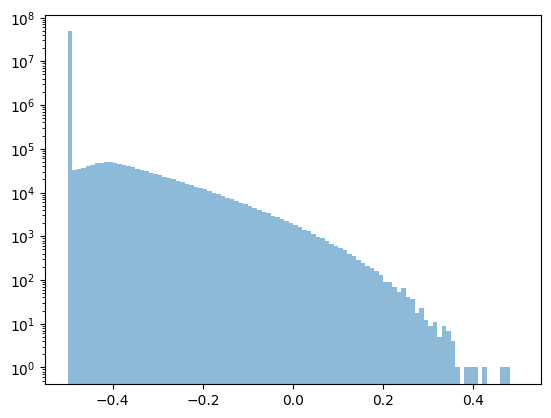

In [12]:
# X_vel.shape
# np.array(v_halos_all).shape
pl.figure()
_ = pl.hist(Mhalos_truth_tensor.cpu().numpy().flatten(), bins=100, alpha=0.5, range=(-0.5,0.5)) 
pl.yscale('log')




In [14]:
X_vel_jb.shape


torch.Size([1, 4096000, 36])

In [15]:
iter_num = 0
local_iter_num = 0 # number of iterations in the lifetime of this process
# raw_model = model.module
running_mfu = -1.0    
best_val_loss = 1e20
nbatches = 10
max_iters = 8000
eval_interval = 20
save_separate_interval = 20
loss_min = 1e20

nepochs = 8000

for iter_num in (range(nepochs)):
    lr = get_lr(iter_num, model=decay_lr_model) if decay_lr else learning_rate
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


    loss = model(
        X_vel_jb,
        cond_tensor_jb,
        cond_tensor_nsh_jb,
        cond_cosmo_jb,
        Nhalos_truth_tensor_jb,
        Mhalos_truth_tensor_jb,
        mask_tensor_vel_train_jb         
        )            

    scaler.scale(loss).backward()   
    if (iter_num % 10) == 0:
        print(f"iter {iter_num}, loss: {loss.item()}")                 


    if (np.mod(iter_num, int(nepochs / 80)) == 0) or (iter_num == nepochs - 1):
        if float(loss.mean().cpu().detach().numpy()) < loss_min:
            loss_min = float(loss.mean().cpu().detach().numpy())
            print(loss_min)

            state = {'loss_min': loss_min, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict(),
                        'loss':loss}

            # save_bestfit_model_name = sdir_model_checkpoint + 'test_model_bestfit_' + str(iter_num) + '.pth'
            # torch.save(
            #     state, save_bestfit_model_name
            #     )

    scaler.step(optimizer)
    scaler.update()
    # flush the gradients as soon as we can, no need for this memory anymore
    optimizer.zero_grad(set_to_none=True)



# dist.destroy_process_group()

# if __name__ == "__main__":
#     run_func()



/mnt/home/spandey/miniconda3/envs/ili-sbi/lib/python3.10/site-packages/torch/nn/modules/conv.py:605: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv3d(


iter 0, loss: 4.493227005004883
4.493227005004883
iter 10, loss: 4.336228847503662
iter 20, loss: 3.8562684059143066
iter 30, loss: 3.0852980613708496
iter 40, loss: 2.09580659866333
iter 50, loss: 1.0626099109649658


KeyboardInterrupt: 

In [8]:
# loss
X_vel_jb

tensor([], device='cuda:0', size=(0, 4096000, 36))

In [ ]:
decay_lr = True # whether to decay the learning rate
decay_lr_model = 'cosine'
warmup_iters = 500 # how many steps to warm up for
lr_decay_iters = 7500 # should be ~= max_iters per Chinchilla
min_lr = 1e-4 # minimum learning rate, should be ~= learning_rate/10 per Chinchilla

def get_lr(it, model='cosine'):
    # 1) linear warmup for warmup_iters steps
    if model == 'cosine':
        if it < warmup_iters:
            return learning_rate * it / warmup_iters
        # 2) if it > lr_decay_iters, return min learning rate
        if it > lr_decay_iters:
            return min_lr
        # 3) in between, use cosine decay down to min learning rate
        decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
        assert 0 <= decay_ratio <= 1
        coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff ranges 0..1
        return min_lr + coeff * (learning_rate - min_lr)
    
    elif model == 'linear':
        if it < warmup_iters:
            return learning_rate * it / warmup_iters
        else:
            return learning_rate - (it - warmup_iters) * (learning_rate - min_lr) / (lr_decay_iters - warmup_iters)

    elif model == 'constant':
        return learning_rate



In [11]:
max_iters = 8000
# cond_tensor_jb.shape
# cond_tensor_nsh_jb.shape
lr_test = np.zeros(max_iters)
for ji in range(max_iters):
    lr_test[ji] = get_lr(ji, model=decay_lr_model)


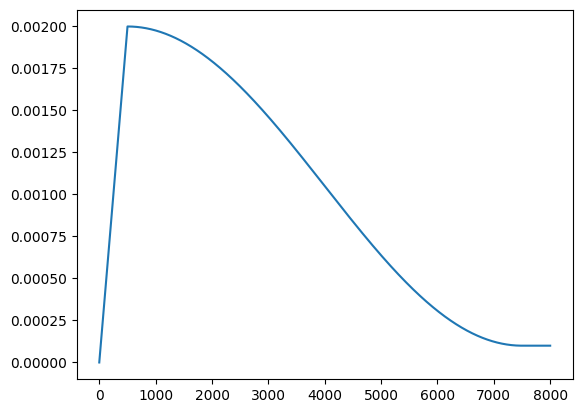

In [13]:
import matplotlib.pyplot as pl
%matplotlib inline
pl.figure()
pl.plot(lr_test)


In [7]:
device_id = torch.device("cuda")
ndim_diff = Nmax - 1
ndim_mass = Nmax
ndim_vel = 3*Nmax

lgM_array = np.linspace(lgMmin, lgMmax, 1000)
M_array = 10**lgM_array
if '200c' in mass_type:
    hmf = mass_function.massFunction(M_array, float(z_inference), mdef = '200c', model = 'tinker08', q_out = 'dndlnM')
if 'vir' in mass_type:
    hmf = mass_function.massFunction(M_array, float(z_inference), mdef = 'vir', model = 'tinker08', q_out = 'dndlnM')    
if 'fof' in mass_type:
    hmf = mass_function.massFunction(M_array, float(z_inference), mdef = 'fof', model = 'bhattacharya11', q_out = 'dndlnM')
lgM_rescaled = rescale_sub + (lgM_array - lgMmin)/(lgMmax-lgMmin)

int_val = sp.integrate.simps(hmf, lgM_rescaled)
hmf_pdf = hmf/int_val
# define the cdf of the halo mass function
hmf_cdf = np.zeros_like(hmf_pdf)
for i in range(len(hmf_cdf)):
    hmf_cdf[i] = sp.integrate.simps(hmf_pdf[:i+1], lgM_rescaled[:i+1])

if 'sigv' in config:
    sigv = config['sigv']
else:
    sigv = 0.05
    
num_cond_vel = num_cond + ndim_mass
model_vel = NSF_Autoreg_CNNcond(
    dim=ndim_vel,
    K=K_vel,
    B=B_vel,
    hidden_dim=hidden_dim_MAF,
    num_cond=num_cond_vel,
    nflows=nflows_vel_NSF,
    base_dist=base_dist_vel,
    mu_pos=False
    )


# ndim = ndim_diff + 1
model = COMBINED_Model_vel_only(
    None,
    model_vel,
    ndim_vel,
    ksize,
    ns_d,
    ns_h,
    nb,
    ninp,
    nfeature_cnn,
    nout_cnn,
    layers_types=layers_types,
    act='tanh',
    padding='valid',
    ).to(device_id)

# model = DDP(model, device_ids=[device_id], find_unused_parameters=True)

model = torch.nn.DataParallel(model)


/tmp/ipykernel_1426269/684644009.py:16: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  int_val = sp.integrate.simps(hmf, lgM_rescaled)
/tmp/ipykernel_1426269/684644009.py:21: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  hmf_cdf[i] = sp.integrate.simps(hmf_pdf[:i+1], lgM_rescaled[:i+1])


In [8]:
ldir_cp = '/mnt/home/spandey/ceph/CHARM/model_checkpoints/test1_vel/'

checkpoint = torch.load(ldir_cp + f'test_model_bestfit_800.pth', map_location=device_id)
# print(iter)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
print()


In [9]:
test_id = 3

ldir_f = '/mnt/home/spandey/ceph/Quijote/data_NGP_self_fastpm_LH/'

n_dim_red = (nf - 1) // 2
n_pad = n_dim_red * nc

df_zg = pk.load(open(ldir_f + '%d/density_HR_full_m_res_128_z=0.5_nbatch_8_nfilter_3_ncnn_0.pk'%test_id,'rb'))
df_test_zg = df_zg['density_cic_unpad_combined']
df_test_pad_zg = np.pad(df_test_zg, n_pad, 'wrap')



z_REDSHIFT = float(z_all_FP[-1].split('_')[1])
if z_REDSHIFT == 0.0:
    z_REDSHIFT = 0

df_load = pk.load(open(
    ldir_f + '/' + str(test_id) + '/velocity_HR_full_m_res_128_z=' + str(z_REDSHIFT) + '_nbatch_8_nfilter_3_ncnn_0.pk', 'rb')
    )

vel_all = df_load['velocity_cic_unpad_combined']
# # vel_pad_all = 
vel_pad = np.stack([np.pad(vel_all[j,...], n_pad, 'wrap') for j in range(3)], axis=0)

df_test_all_pad = np.concatenate([np.log(1 + df_test_pad_zg + 1e-10)[None,...], vel_pad], axis=0)[None, None,:]
# df_test_all_pad = np.stack([np.log(1 + df_test_pad_zg + 1e-10), np.log(
#     1 + df_test_pad_zIC + 1e-10), df_test_pad_constrast_zg], axis=0)[None, None, :]

# df_test_all_pad.shape

# density_smoothed = gaussian_filter(df_test_zg, sigma=VALUE_SIG)
# df_test_constrast_zg = density_smoothed - df_test_zg
# 
df_test_all_unpad = np.concatenate([np.log(1 + df_test_zg + 1e-10)[None,...], vel_all], axis=0)[None, None,:]
# df_test_all_unpad = np.stack([np.log(1 + df_test_zg + 1e-10), np.log(
#     1 + df_test_zIC + 1e-10), df_test_constrast_zg], axis=0)[None, None, :]

# df_test_all_unpad.shape

cond_nsh_test = np.moveaxis(df_test_all_unpad, 2, 5)
nsims_test = cond_nsh_test.shape[1]
nax_h_test = cond_nsh_test.shape[2]
ninp_test = cond_nsh_test.shape[-1]
cond_tensor_nsh_test = torch.Tensor(np.copy(cond_nsh_test.reshape(1,nsims_test * (nax_h_test ** 3), ninp_test))).cuda(device_id)    

# cond_tensor_nsh_test.shape
LH_cosmo_val_file='/mnt/home/spandey/ceph/Quijote/latin_hypercube_params.txt'
LH_cosmo_val_all = np.loadtxt(LH_cosmo_val_file)
fid_cosmo_val_all = LH_cosmo_val_all[test_id]
# fid_cosmo_val_all = np.array([0.3175, 0.049, 0.6711, 0.9624, 0.64])  

cosmo_val_test = np.tile(fid_cosmo_val_all, (cond_tensor_nsh_test.shape[1] ,1))[None,:]

# cosmo_val_test.shape
# df_test_all_pad.shape, df_test_all_unpad.shape, cosmo_val_test.shape
df_test_all_pad = torch.tensor(df_test_all_pad).to(device_id)
df_test_all_unpad = torch.tensor(cond_tensor_nsh_test).to(device_id)
cosmo_val_test = torch.tensor(cosmo_val_test, dtype=torch.float32).to(device_id)




/tmp/ipykernel_1426269/952882934.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  df_test_all_unpad = torch.tensor(cond_tensor_nsh_test).to(device_id)


In [10]:
import pickle as pk
from scipy.interpolate import RegularGridInterpolator
grid = 128
BoxSize = 1000.
xall = (np.linspace(0, BoxSize, grid + 1))
xarray = 0.5 * (xall[1:] + xall[:-1])
yarray = np.copy(xarray)
zarray = np.copy(xarray)

vel_load_dir = '/mnt/home/spandey/ceph/Quijote/data_NGP_self_fastpm_LH/'
df = pk.load(open(vel_load_dir + f'{test_id}/velocity_HR_full_m_res_128_z=0.5_nbatch_8_nfilter_3_ncnn_0.pk', 'rb'))['velocity_cic_unpad_combined']
# df.shape
vx_mesh_load = 1000.*df[0,...]
vy_mesh_load = 1000.*df[1,...]
vz_mesh_load = 1000.*df[2,...]

vx_all_3D_interp_l = RegularGridInterpolator((xarray, yarray, zarray), vx_mesh_load, bounds_error=False, fill_value=None)
vy_all_3D_interp_l = RegularGridInterpolator((xarray, yarray, zarray), vy_mesh_load, bounds_error=False, fill_value=None)
vz_all_3D_interp_l = RegularGridInterpolator((xarray, yarray, zarray), vz_mesh_load, bounds_error=False, fill_value=None)

vx_eval_interp_l = vx_all_3D_interp_l(pos_h_mock)
vy_eval_interp_l = vy_all_3D_interp_l(pos_h_mock)
vz_eval_interp_l = vz_all_3D_interp_l(pos_h_mock)






NameError: name 'pos_h_mock' is not defined

In [9]:
train_Ntot, train_M1, train_Mdiff = 1, 1, 1
train_binary, train_multi = 1, 1
# if verbose:
    # print(f"Running the model")

# run the model
Ntot_samp_test, M1_samp_test, M_diff_samp_test, mask_tensor_M1_samp_test, mask_tensor_Mdiff_samp_test, _ = model.module.inverse(
    cond_x=df_test_all_pad,
    cond_x_nsh=df_test_all_unpad,
    cond_cosmo=cosmo_val_test,
    use_truth_Nhalo=1-train_Ntot,
    use_truth_M1=1-train_M1,
    use_truth_Mdiff=1-train_Mdiff,
    mask_Mdiff_truth=None,
    mask_M1_truth=None,
    Nhalos_truth=None,
    M1_truth=None,
    Mdiff_truth=None,
    train_binary=train_binary,
    train_multi=train_multi,
    train_M1=train_M1,
    train_Mdiff=train_Mdiff,
)




In [6]:
# df_test_all_pad


array([[[[[[-6.41574621e-01, -1.72133759e-01, -7.63979733e-01, ...,
            -4.71251518e-01, -1.68907061e-01,  1.67815924e-01],
           [ 6.11402035e-01,  9.48579907e-01, -2.95260344e-02, ...,
            -8.41420412e-01, -7.30655789e-01, -4.54042368e-02],
           [ 1.30195946e-01,  1.58320859e-01,  1.60618782e-01, ...,
            -2.21391588e-01,  6.43700287e-02,  3.90518427e-01],
           ...,
           [ 1.11450024e-01, -4.54131246e-01, -6.29319966e-01, ...,
            -6.23841047e-01, -5.95678568e-01, -9.24254596e-01],
           [-1.38934970e-01,  2.00465351e-01, -6.42176270e-02, ...,
            -4.06537384e-01, -5.43448448e-01, -1.48078549e+00],
           [-4.84026670e-01,  3.44930202e-01,  1.86896980e-01, ...,
             4.86762412e-02, -1.14738338e-01, -1.31429398e+00]],

          [[-7.01996982e-01, -1.67766571e-01, -6.30586147e-01, ...,
            -4.08667214e-02, -4.38184261e-01,  1.20643891e-01],
           [ 2.74020702e-01,  5.98724723e-01,  2.30959192e

In [10]:
BoxSize=1000
# Ntot_samp_test[0].shape
Ntot_samp_test_rs = Ntot_samp_test[0][:, np.newaxis]
M1_samp_test_rs = (M1_samp_test[0] * mask_tensor_M1_samp_test[0][:, 0]).cpu().detach().numpy()
M_diff_samp_test_rs = (M_diff_samp_test[0] * mask_tensor_Mdiff_samp_test[0]).cpu().detach().numpy()




Ntot_samp_test = Ntot_samp_test[0][:, np.newaxis]
save_subvol_Nhalo = Ntot_samp_test.reshape(
    nsims_test, nax_h_test, nax_h_test, nax_h_test)
save_subvol_M1 = (M1_samp_test[0] * mask_tensor_M1_samp_test[0][:, 0]
                    ).cpu().detach().numpy().reshape(nsims_test, nax_h_test, nax_h_test, nax_h_test, 1)
save_subvol_Mdiff = (M_diff_samp_test[0] * mask_tensor_Mdiff_samp_test[0]
                        ).cpu().detach().numpy().reshape(nsims_test, nax_h_test, nax_h_test, nax_h_test, ndim_diff)

mask_subvol_Mtot1 = mask_tensor_M1_samp_test[0].cpu().detach().numpy().reshape(
    nsims_test, nax_h_test, nax_h_test, nax_h_test)[..., None]
mask_subvol_Mtot2 = mask_tensor_Mdiff_samp_test[0].cpu().detach().numpy(
).reshape(nsims_test, nax_h_test, nax_h_test, nax_h_test, ndim_diff)
mask_subvol_Mtot = np.concatenate(
    [mask_subvol_Mtot1, mask_subvol_Mtot2], axis=-1)

# compute the mass of halos from output
save_subvol_Mtot = np.zeros(
    (nsims_test, nax_h_test, nax_h_test, nax_h_test, ndim_diff + 1))
# Mmin, Mmax = return_dict_test['Mmin'], return_dict_test['Mmax']
for jd in range(ndim_diff + 1):
    if jd == 0:
        save_subvol_Mtot[..., jd] = (
            save_subvol_M1[..., 0] + 0.5) * (lgMmax - lgMmin) + lgMmin
    else:
        save_subvol_Mtot[...,
                            jd] = (save_subvol_Mtot[..., jd - 1]) - (save_subvol_Mdiff[..., jd - 1]) * (lgMmax - lgMmin)

save_subvol_Mtot *= mask_subvol_Mtot

Nhalos = save_subvol_Nhalo[0, ...]  # histogram of halos in each voxel
M_halos = save_subvol_Mtot[0, ...]  # mass of halos in each voxel

# create the meshgrid
xall = (np.linspace(0, BoxSize, ns_h + 1))
xarray = 0.5 * (xall[1:] + xall[:-1])
yarray = np.copy(xarray)
zarray = np.copy(xarray)
x_cy, y_cy, z_cy = np.meshgrid(xarray, yarray, zarray, indexing='ij')

# record discrete halo positions and masses
x_h_mock, y_h_mock, z_h_mock, lgM_mock = [], [], [], []
# Nmax_sel = 3
k = 0
for jx in range(ns_h):
    for jy in range(ns_h):
        for jz in range(ns_h):
            Nh_vox = int(Nhalos[jx, jy, jz])
            if Nh_vox > 0:
                x_h_mock.append(x_cy[jx, jy, jz]*np.ones(Nh_vox))
                y_h_mock.append(y_cy[jx, jy, jz]*np.ones(Nh_vox))
                z_h_mock.append(z_cy[jx, jy, jz]*np.ones(Nh_vox))

                lgM_mock.append((M_halos[jx, jy, jz, :Nh_vox]))
                k += Nh_vox

# convert to numpy arrays
x_h_mock = np.concatenate(x_h_mock)
y_h_mock = np.concatenate(y_h_mock)
z_h_mock = np.concatenate(z_h_mock)
pos_h_mock = np.vstack((x_h_mock, y_h_mock, z_h_mock)).T
lgMass_mock = np.concatenate(lgM_mock)
# convert to float data type
pos_h_mock = pos_h_mock.astype('float32')
lgMass_mock = lgMass_mock.astype('float32')





In [11]:
isim = test_id
# snap_dir_base = '/mnt/home/fvillaescusa/ceph/Quijote/Halos/Rockstar/fiducial_HR'
snap_dir_base = '/mnt/home/fvillaescusa/ceph/Quijote/Halos/Rockstar/latin_hypercube_HR'
snapnum = 3
MAS     = 'NGP'  #mass-assigment scheme
verbose = False   #print information on progress
snapdir = snap_dir_base + '/' + str(isim)  #folder hosting the catalogue
rockstar = np.loadtxt(snapdir + '/out_' + str(snapnum) + '_pid.list')
with open(snapdir + '/out_' + str(snapnum) + '_pid.list', 'r') as f:
    lines = f.readlines()
header = lines[0].split()
# get the properties of the halos
pos_h_truth = rockstar[:,header.index('X'):header.index('Z')+1]
index_M = header.index('M200c')                    
mass_truth = rockstar[:,index_M]  #Halo masses in Msun/h
lgMass_truth = np.log10(mass_truth).astype(np.float32)
vel_h_truth = rockstar[:,header.index('VX'):header.index('VZ')+1]

indsel = np.where(mass_truth > 1e13)[0]
pos_h_truth = pos_h_truth[indsel]
vel_h_truth = vel_h_truth[indsel]
lgMass_truth = lgMass_truth[indsel]




/tmp/ipykernel_2608460/577627419.py:16: RuntimeWarning: divide by zero encountered in log10
  lgMass_truth = np.log10(mass_truth).astype(np.float32)


In [12]:
import Pk_library as PKL
import MAS_library as MASL
grid_Pk_full = 128
MAS = 'NGP'
threads = 10
mesh_orig = np.zeros((grid_Pk_full, grid_Pk_full, grid_Pk_full), dtype=np.float32)
MASL.MA(pos_h_truth.astype(np.float32), mesh_orig, 1000., MAS)
mesh_orig /= np.mean(mesh_orig, dtype=np.float64);  mesh_orig -= 1.0
Pk_orig_real = PKL.Pk(mesh_orig, 1000., axis=0, MAS=MAS, threads=threads, verbose=False)

mesh_charm = np.zeros((grid_Pk_full, grid_Pk_full, grid_Pk_full), dtype=np.float32)
MASL.MA(pos_h_mock.astype(np.float32), mesh_charm, 1000., MAS)
mesh_charm /= np.mean(mesh_charm, dtype=np.float64);  mesh_charm -= 1.0
Pk_charm_real = PKL.Pk(mesh_charm, 1000., axis=0, MAS=MAS, threads=threads, verbose=False)



Text(0.5, 1.0, 'Real Pk, LH=3')

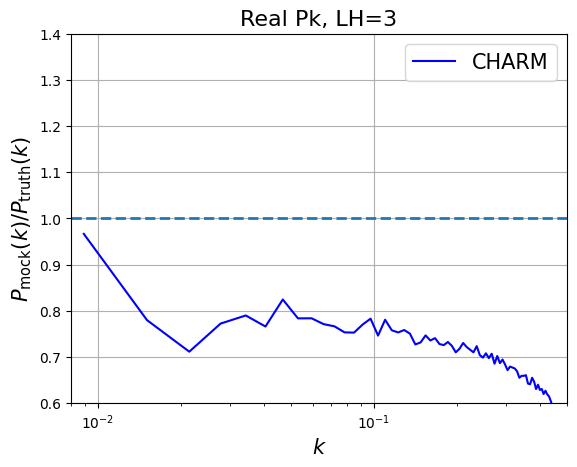

In [16]:
pl.figure()
# pl.plot(Pk_orig_rsd.k3D, Pk_pm_rsd.Pk[:,0]/Pk_orig_rsd.Pk[:,0], color='k', ls='-', alpha=1.0, label='FastPM')
pl.plot(Pk_orig_real.k3D, Pk_charm_real.Pk[:,0]/Pk_orig_real.Pk[:,0], color='b', ls='-', alpha=1.0, label='CHARM')
pl.axhline(1.0, ls='--', lw=2.0)
pl.xscale('log')
pl.ylim(0.6, 1.4)
pl.xlim(0.008, 0.5)
pl.xlabel(r'$k$', size=15)
pl.grid()
pl.legend(fontsize=15)
pl.ylabel(r'$P_{\rm mock}(k)/P_{\rm truth}(k)$', size=15)
pl.title(f'Real Pk, LH={test_id}', size=16)
# pl.savefig(sdirf + '/mono/' + f'NEW_monopole_Pk_{iter}.png', dpi=300,bbox_inches='tight')


